# Dissertation: Community Detection Illustration

In [2]:
import networkx as nx
import networkx.algorithms.community as nx_comm
import random
import itertools
from networkx.generators.community import LFR_benchmark_graph
from sklearn.metrics.cluster import normalized_mutual_info_score
import random
from scipy.optimize import linear_sum_assignment
import numpy as np
import pandas as pd    
from operator import itemgetter


# For plotting
import matplotlib.pyplot as plt

## Customized Function Used in the disseratation

### NMI Evaluation

In [505]:
def nmi_calculator(true_label, pred_label, G=None):
    """
    The function takes 2 parameters, one is the ground truth and the other is the result
    of an algorithm. The function will then construct lists of labels corresponding to 
    ther order of node. After construction of label list, we call the mni score function
    from scikit package for calculation.
    """
    if G:
        pred_label_list = [0]*len(G)
        true_label_list = [0]*len(G)
        for index, comm in enumerate(true_label):
            for node in comm:
                true_label_list[node] = index
                    
        for index, comm in enumerate(pred_label):
            for node in comm:
                pred_label_list[node] = index
    elif isinstance(true_label, list) and isinstance(pred_label, list):
        pred_label_list = pred_label
        true_label_list = true_label
    else:
        raise ValueError
    nmi_score = normalized_mutual_info_score(true_label_list, pred_label_list)

    return nmi_score

### Relabel Mechanics for aNMI evaluation

In [140]:
def relabel(ground_truth = [1, 1, 1, 1, 4, 4, 2, 2, 3, 3], computed_label = [3, 3, 3, 3, 3, 3, 3, 1, 1, 2], G = None):
    """
    The function takes 2 partitions, one be the ground truth partition and the other is the computed partition.
    The function will first compute the cost matrix (commented below), and find the solution of minimum weight
    using Hungarian algorithm. Lastly, returns a dictionary with key as label in computed partition and value as
    the label in ground truth partition. 
    
    For Hungarian algorithm, please check https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.linear_sum_assignment.html for more info.
    For more detailed relabel mechanics, please check https://arxiv.org/pdf/1807.01130.pdf Page 6/
    
    ground_truth: List of real numbers or tuple of set
    computed_label: List of real numbers or tuple of set
    G: The network that is analyzed.
    
    dict_relabel: Dictionary
    """

    if G:
        pred_label_list = [0]*len(G)
        true_label_list = [0]*len(G)
        for index, comm in enumerate(ground_truth):
            for node in comm:
                true_label_list[node] = index
        for index, comm in enumerate(computed_label):
            
            for node in comm:
                pred_label_list[node] = index
                
        ground_truth = true_label_list
        computed_label = pred_label_list
    elif isinstance(ground_truth, list) and isinstance(computed_label, list):
        pass
    else:
        raise ValueError
    
    # {label: {collection of index where matches the label}}
    dict_ground_truth, dict_computed_label = {}, {}

    # Map Function helps converting result of cost matrix coordinates to actual given labels
    # {label for computation : actual label}
    map_ground_truth_index, map_computed_index = {}, {}
    for index, label in enumerate(ground_truth):
        if label not in dict_ground_truth:
            dict_ground_truth[label] = set()
            map_ground_truth_index[label] = len(map_ground_truth_index)
        dict_ground_truth[label].add(index)
    for index, label in enumerate(computed_label):
        if label not in dict_computed_label:
            dict_computed_label[label] = set()
            map_computed_index[label] = len(map_computed_index)
        dict_computed_label[label].add(index)

    # Generate Cost Matrix
    arr_cost_matrix = np.asarray([[0]*len(dict_ground_truth)] * len(dict_computed_label))
    for ground_label, set_ground_label in dict_ground_truth.items():
        for computed_label, set_computed_label in dict_computed_label.items():
            col_ind, row_ind = map_ground_truth_index[ground_label], map_computed_index[computed_label]

            # Cost Function C_ij = |A U B| - |A n B|
            arr_cost_matrix[row_ind][col_ind] = len(set_ground_label.union(set_computed_label)) - len(set_ground_label.intersection(set_computed_label))


    # Generate relabel dictionary
    row_ind, col_ind = linear_sum_assignment(arr_cost_matrix)
    reverse_map_ground_truth = {v:k for k,v in map_ground_truth_index.items()}
    reverse_map_computed_label = {v:k for k,v in map_computed_index.items()}

    dict_relabel = {}
    for index, temp_ground_truth_index in enumerate(col_ind):
        dict_relabel[reverse_map_computed_label[row_ind[index]]] = reverse_map_ground_truth[temp_ground_truth_index]

    return dict_relabel

def relabel_partition_converter(ground_truth, partition, G):
    """
    Ground_truth: list\tuple
    """
    relabeled_partition = [set() for _ in range(len(ground_truth))]
    for computed_label, ground_truth_label in relabel(ground_truth, partition, G).items():
        relabeled_partition[ground_truth_label] = partition[computed_label].copy()
    return relabeled_partition

### aNMI Evaluation

In [139]:
def scale_check(true_label, pred_label, G=None):
    """
    The function takes true labels and predicted labels as input.
    Returns a indicator of partition between the inputs in float, ranges from 0 to 1(inclusive).
    1 being perfectly match
    0 being randomly permutation, meaning no trait of any similarity. 
    """
    
    
    if G:
        pred_label_list = [0]*len(G)
        true_label_list = [0]*len(G)
        for index, comm in enumerate(true_label):
            for node in comm:
                true_label_list[node] = index
        for index, comm in enumerate(pred_label):
            for node in comm:
                pred_label_list[node] = index
                
        true_label = true_label_list
        pred_label = pred_label_list
    elif isinstance(true_label, list) and isinstance(pred_label, list):
        pass
    else:
        raise ValueError
        
    d_true = {}
    for label in true_label:
        if label in d_true:
            d_true[label] += 1 
        else:
            d_true[label] = 1

    d_pred = {}
    for label in pred_label:
        if label in d_pred:
            d_pred[label] += 1 
        else:
            d_pred[label] = 1
    
    d_accurate = {}
    for index, label in enumerate(true_label):
        if pred_label[index] == label:
            if label not in d_accurate:
                d_accurate[label] = 0
            d_accurate[label] += 1

    d_eval = {}
    for k, v in d_true.items():
        if k not in d_pred:
            continue

        ground_count = v
        accurate_count = d_accurate[k] if k in d_accurate else 0
        pred_count = d_pred[k]

        # Scale Check: 1 - abs(pred_count - ground_count)/abs(pred_count + ground_count) -> 1 the best, 0 the worst.
        # Accuracy Check: accurate_count/ground_count -> 1 the best, 0 the worst

        # float_scale_check = 1 - abs(pred_count - ground_count)/(pred_count + ground_count)
        float_scale_check = (accurate_count - ground_count)/(ground_count)
        
        d_eval[k] = float_scale_check
        
        # return 0 if network is not labled
    if not d_eval:
        return 0
    return sum(d_eval.values())/len(d_eval), sum(d_accurate.values())

def adaptive_nmi(true_label, pred_label, G=None):
    
    if G:
        pred_label = relabel_partition_converter(true_label, pred_label, G)
    scale_value, scale_weight = scale_check(true_label, pred_label, G)
    nmi_value = nmi_calculator(true_label, pred_label, G)
    alpha = beta = 1/2
    if G:
        alpha = scale_weight/len(G)
        beta = (len(G) - scale_weight)/len(G)
    return (alpha * nmi_value + beta * (scale_value + 1))

### Customized Coloring/Plotting Functions

In [5]:
def color_by_community(G, communities):
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(communities))]

    color_map = []
    for node in G:
        for group_index, group in enumerate(communities):
            if node in group: color_map.append(color[group_index])

    # print("Partition via the method is:\n\n" + "\n".join([str(ele) for ele in communities]))
    my_pos = nx.spring_layout(G, seed = 100)
    nx.draw(G, node_color=color_map, with_labels=True, pos=my_pos)
    return G

def GN_plot_by_eval(G, ground_truth_label, list_of_eval):
    best_score_index = list_of_eval.index(max(list_of_eval))
    comp = nx_comm.girvan_newman(G)
    if best_score_index != 0:
        [next(comp) for i in range(best_score_index)]
    best_partition = next(comp)
    color = ["#00FFFF", "#FF4040", "#76EE00",  "#00EE76", "#FFFF00"]

    color_map = []
    for node in G:
        for group_index, group in enumerate(best_partition):
            if node in group: color_map.append(color[group_index])

    my_pos = nx.spring_layout(G, seed = 100)
    nx.draw(G, node_color=color_map, with_labels=True, pos=my_pos)
    print(len(ground_truth_label[0] - best_partition[0]), max(list_of_eval), best_score_index+1)
    return G, best_partition

## Generate Graph without Label
We can use call the networkx library to construct random graphs with given count of nodes and count of edges.

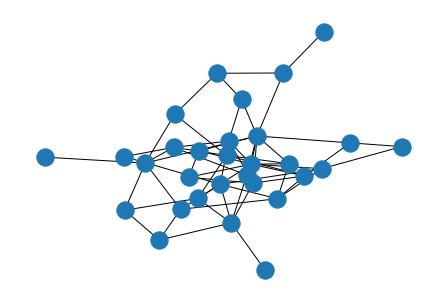

In [55]:
G = nx.gnm_random_graph(30,60)
nx.draw(G)

## Louvain Algorithm

Partition via Louvain's method is:

{18, 3, 2, 5, 7, 13, 15}
{6, 8, 26, 11, 29, 14}
{17, 4, 9, 28, 25}
{1, 19, 21, 22, 23}
{16, 0, 20, 24, 10, 27, 12}


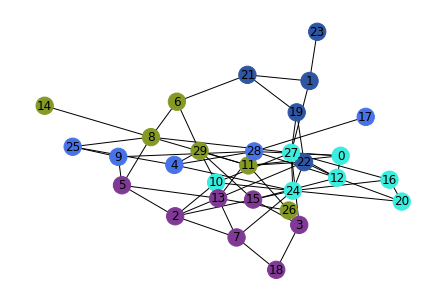

In [56]:
p1 = nx_comm.louvain_communities(G)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(len(p1))]

color_map = []
for node in G:
    for group_index, group in enumerate(p1):
        if node in group: color_map.append(color[group_index])
print("Partition via Louvain's method is:\n\n" + "\n".join([str(ele) for ele in p1]))
nx.draw(G, node_color=color_map, with_labels=True)

## Girvan-Newman Algorithm

In this section, we implement Girvan-Newman algorithm to the graph for illustration. Due to the nature of algorithm, we can conduct the partition iteratively and observe how it works. For simplicity purpose, the partition of the 6th iteration is chosen for this section.

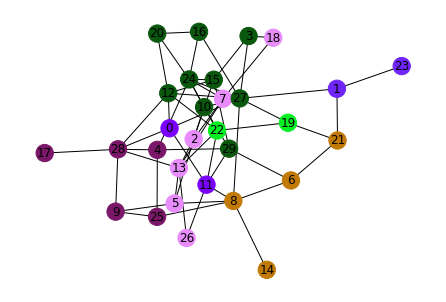

In [57]:
comp = nx_comm.girvan_newman(G)
[next(comp) for i in range(5)]
color_by_community(G, next(comp))

## Creating Artificial Network For Algorithm Testing

In the previous section, we created a network without labels. The labeling process does not affect the performance of algorithms, but can evaluate how accurate a result of a algorithm is. 

### LFR benchmark graph

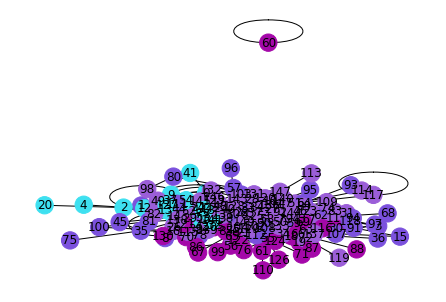

In [58]:
# https://networkx.org/documentation/stable/reference/generated/networkx.generators.community.LFR_benchmark_graph.html
n = 150
tau1 = 2
tau2 = 1.2
mu = 0.3
G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=4, min_community=20, seed=10
)
color_by_community(G, communities = {frozenset(G.nodes[v]["community"]) for v in G})

## Evaluation
To evaluate the result of algorithm, we can either compute their performance, which is $$\frac{\text{edge of intra-community} + \text{non-edge of inter-community}}{\text{total potential edges}}.$$ Normally, higher the performance will result in better partition since either more edges inside each community or less edges between communities.

However, the performance evaluation does not take the true labels into consideration, it solely consider the structure and the 'tightness' of the partition. To compute the accuracy of a partition, we introduce the normalized mutual information. The idea is learned from the information theory. The NMI takes two parameters: a ground-truth partition and a computed partion. The math part behind NMI can be found [here](https://luisdrita.com/normalized-mutual-information-a10785ba4898). In short, the NMI score is between 0 and 1(inclusive), 1 indicates the two partition are perfectly correlated while 0 indicates two partitions are completely not correlated.

### Performance of Louvain Algorithm
We can see the the performance of Louvain algorithm is 0.87 which is pretty good.

0.8795525727069351


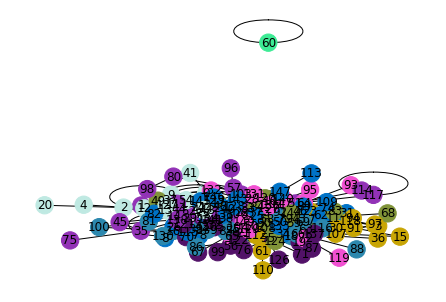

In [59]:
p1 = nx_comm.louvain_communities(G)
print(nx_comm.partition_quality(G, p1)[1])
color_by_community(G, p1)


### Performance of Grivan Newman Algorithm
Since GN algorithm is a divisive hierarchical algorithm, we can iterate a bit more generations and see how it goes. We can tell that as the iteration increases, the performance can eventually approach to 1 since all the node will ultimately turn into a community.

Text(0, 0.5, 'Performance')

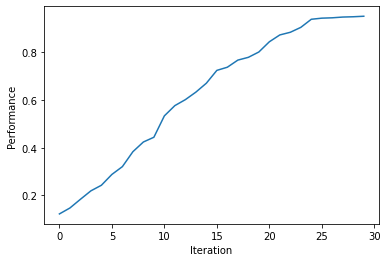

In [60]:
iteration = [i for i in range(30)]
comp = nx_comm.girvan_newman(G)
perforamnce = [nx_comm.partition_quality(G, next(comp))[1] for i in range(30)]

plt.plot(iteration, perforamnce)
plt.xlabel('Iteration')
plt.ylabel('Performance')

### Normalized Mutual Information Evalutation
As meanioned, we can expect the score of NMI to be higher if the partition of an algorithm is more *similar* to the ground truth partition, and lower the value otherwise. Since there is not in-built function to do the job, let's make one here.

In [61]:
ground_truth = {frozenset(G.nodes[v]["community"]) for v in G}

### NMI Score of Louvain Algorithm

The result of the calcuation indicates that the partition of louvain algorithm may not reveal the true labels perfectly.

In [62]:
nmi_calculator(ground_truth, p1, G)

0.37725581979080075

### NMI Score of Girvan Newman Algorithm

Similar to retrieving the performance of Girvan Newman algorithm, we can run the evaluation iteratively and find the best result.

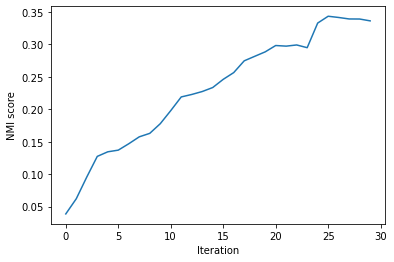

In [63]:
iteration = [i for i in range(30)]
comp = nx_comm.girvan_newman(G)
nmi_score_list = [nmi_calculator(ground_truth, next(comp), G) for i in range(30)]

plt.plot(iteration, nmi_score_list)
plt.xlabel('Iteration')
plt.ylabel('NMI score')

best_score_index = nmi_score_list.index(max(nmi_score_list))
best_score = max(nmi_score_list)

The result indicates that at iteration 1, the NMI score peaks to the max, which is 0.90. The NMI score suggest that the partition of GN algorithm at the first iteration is highly correlated to the ground truth. Unsuprisingly, by implementing visual comparison, we can observe the high similarity between the partition and the ground truth.

The best NMI score is achieved at iteration 25 with NMI score of 0.34322579389097974



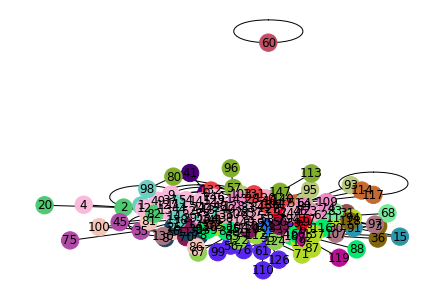

In [64]:
print("The best NMI score is achieved at iteration {} with NMI score of {}\n".format(best_score_index, best_score))

comp = nx_comm.girvan_newman(G)
if best_score_index != 0:
    [next(comp) for i in range(best_score_index)]
color_by_community(G, next(comp))

## Future Work

1. Read more papers about evaluation.
2. Importing real-world dataset.
3. Introduce few more community detection algorithms to my disseration.

## Images for Dissertation

Figure 1: 

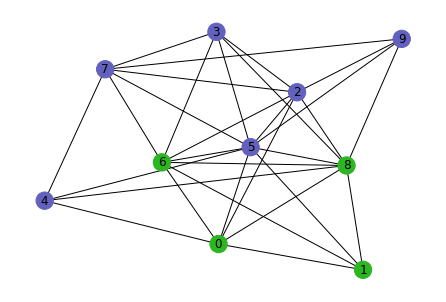

In [65]:
G = nx.gnm_random_graph(10,30)
p1 = nx_comm.louvain_communities(G)
color_by_community(G, p1)
plt.savefig("fig_1.png", format="PNG")


(0.8, 0.9)


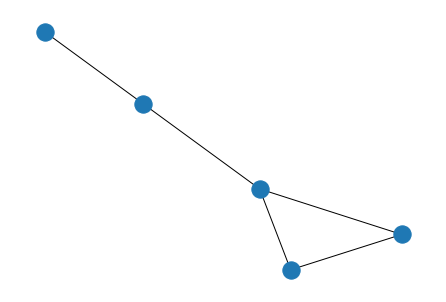

In [66]:
G = nx.Graph()
G.add_nodes_from([_ for _ in range(1,6)])
G.add_edges_from([(1,2),(1,3),(2,3),(3,4),(4,5)])
print(nx_comm.partition_quality(G,[{1,2,3},{4,5}]))

my_pos = nx.spring_layout(G, seed = 100)
nx.draw(G, pos=my_pos)


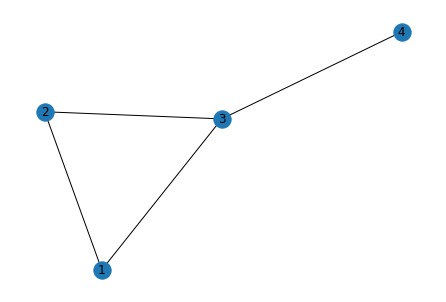

In [67]:
G = nx.Graph()
G.add_nodes_from([_ for _ in range(1,5)])
G.add_edges_from([(1,2),(1,3),(2,3),(3,4)])
my_pos = nx.spring_layout(G, seed = 100)
nx.draw(G, pos=my_pos, with_labels=True)
plt.savefig("fig_1.png", format="PNG")


In [68]:
isinstance(nx.Graph(), nx.classes.graph.Graph)

True

## Measurement of two partitions mentioned in section3 - NMI

In [69]:
print(nmi_calculator([1,1,1,1,1,2,2,2,3,3], [1,1,1,1,2,2,2,2,3,3]),
nmi_calculator([1,1,1,1,1,2,2,2,3,3], [1,1,1,1,1,2,2,2,2,3]))

0.7720707175417086 0.8157307476916307


## Measurement of two paritions mentioned in section3 - aNMI

Discuss that aNMI encourage detecting small community to some extend (0.84 > 0.83), where NMI is fail to detect small communities (0.77 < 0.81). <- Mention this in aNMI section.

In [70]:
print(adaptive_nmi([1,1,1,1,1,2,2,2,3,3], [1,1,1,1,2,2,2,2,3,3]),
adaptive_nmi([1,1,1,1,1,2,2,2,3,3], [1,1,1,1,1,2,2,2,2,3]))

0.852702025437521 0.8245320405124821


In [72]:
# print("The best evaluation score is achieved at iteration {} with evaluation score of {}\n".format(best_score_index, best_score))
best_score_index = nmi_score_list.index(max(nmi_score_list))
comp = nx_comm.girvan_newman(G)
if best_score_index != 0:
    [next(comp) for i in range(best_score_index)]
color_by_community(G, next(comp))

StopIteration: 

Partition via the method is:

frozenset({1, 3, 7, 8, 13, 14, 20, 23, 24, 27, 28, 29, 31, 40, 46, 51, 52, 54, 55, 58, 61, 62, 63, 64, 65, 69, 72, 75, 76, 77, 78, 82, 83, 85, 88, 101, 106, 108, 112, 113, 117, 121, 147, 200, 203, 207, 209, 210, 211, 212, 213, 214, 215, 216, 219, 220, 224, 225, 226, 227, 228, 229, 231, 233, 234, 239, 240, 242, 243, 246, 247, 249})
frozenset({196, 16, 18, 19, 21, 22, 153, 157, 161, 34, 33, 36, 165, 38, 39, 44, 45, 172, 178, 122, 189})
frozenset({0, 2, 4, 5, 6, 9, 10, 11, 12, 15, 17, 25, 26, 30, 32, 35, 37, 41, 42, 43, 47, 48, 49, 50, 53, 56, 57, 59, 60, 66, 67, 68, 70, 71, 73, 74, 79, 80, 81, 84, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 107, 109, 110, 111, 114, 115, 116, 118, 119, 120, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 154, 155, 156, 158, 159, 160, 162, 163, 164, 166, 167, 168, 169, 170, 171, 173, 174, 175, 176, 

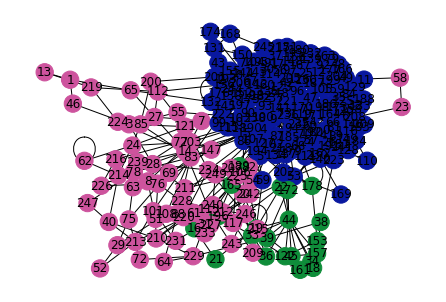

In [305]:
color_by_community(G, ground_truth)

Partition via the method is:

{0, 4, 5, 6, 9, 10, 11, 15, 17, 20, 23, 25, 26, 30, 35, 37, 41, 42, 47, 48, 49, 50, 57, 58, 59, 60, 66, 68, 70, 71, 73, 79, 80, 81, 82, 84, 86, 87, 90, 91, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 105, 106, 107, 109, 110, 111, 114, 115, 119, 120, 123, 124, 125, 127, 128, 133, 134, 135, 137, 139, 140, 141, 142, 143, 145, 146, 148, 149, 151, 152, 154, 156, 159, 160, 163, 164, 167, 170, 171, 173, 175, 177, 180, 181, 182, 183, 184, 185, 186, 187, 188, 190, 191, 192, 194, 197, 198, 199, 201, 202, 204, 205, 206, 208, 217, 218, 221, 223, 230, 232, 235, 236, 237, 238, 241, 248}
{1, 3, 7, 8, 13, 14, 147, 24, 27, 28, 29, 31, 40, 46, 51, 52, 54, 55, 61, 62, 63, 64, 65, 69, 200, 72, 203, 75, 76, 78, 77, 207, 209, 210, 211, 212, 85, 214, 83, 88, 213, 215, 219, 220, 216, 224, 225, 226, 227, 228, 249, 229, 101, 231, 233, 234, 108, 239, 112, 113, 240, 243, 242, 117, 246, 247, 121}
{2, 131, 67, 195, 136, 168, 74, 12, 144, 244, 245, 150, 155, 222}
{16, 18, 19, 21, 22

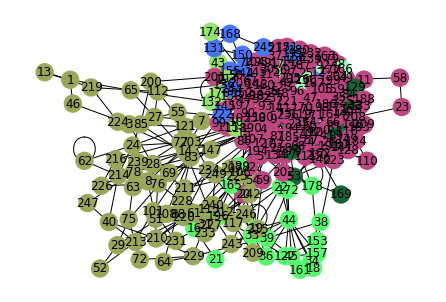

In [306]:
best_score_index = anmi_score_list.index(max(anmi_score_list))
comp = nx_comm.girvan_newman(G)
if best_score_index != 0:
    [next(comp) for i in range(best_score_index)]
color_by_community(G, next(comp))


## Creating Plot of NMI, aNMI, and theoretical line

10000 vertex network

Calculating Flipping Labels
Flipping Labels Complete
Plotting


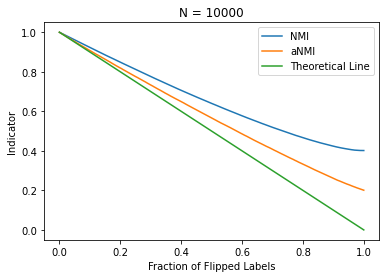

In [176]:
# Create Graph
n = 10000
tau1 = 3
tau2 = 1.5
mu = 0.1
G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=3, min_community=15, seed=10
)
ground_truth = {frozenset(G.nodes[v]["community"]) for v in G}
true_label_list = [0]*len(G)
for index, comm in enumerate(ground_truth):
    for node in comm:
        true_label_list[node] = index
flipped_label_list = true_label_list.copy()
list_nmi_flipped_fraction = []
list_anmi_flipped_fraction = []
list_theoretical = []

print("Calculating Flipping Labels")
for i in range(len(flipped_label_list)):
    
    # flip original label to a different label
    old_label = flipped_label_list[i]
    new_label = random.randint(0, len(ground_truth)-1)
    while new_label == old_label:
            new_label = random.randint(0, len(ground_truth)-1)

    flipped_label_list[i] = new_label
    nmi = nmi_calculator(true_label_list, flipped_label_list)
    anmi = adaptive_nmi(true_label_list, flipped_label_list)
    
    list_nmi_flipped_fraction.append((i/len(flipped_label_list), nmi))
    list_anmi_flipped_fraction.append((i/len(flipped_label_list), anmi))
    list_theoretical.append((i/len(flipped_label_list),1 - i/len(flipped_label_list)))

print("Flipping Labels Complete")
list_nmi_x_axis = [ele[0] for ele in list_nmi_flipped_fraction]
list_nmi_y_axis = [ele[1] for ele in list_nmi_flipped_fraction]

list_anmi_x_axis = [ele[0] for ele in list_anmi_flipped_fraction]
list_anmi_y_axis = [ele[1] for ele in list_anmi_flipped_fraction]

list_theo_x_axis = [ele[0] for ele in list_theoretical]
list_theo_y_axis = [ele[1] for ele in list_theoretical]

print("Plotting")
plt.plot(list_nmi_x_axis, list_nmi_y_axis, label = "NMI")
plt.plot(list_anmi_x_axis, list_anmi_y_axis, label = "aNMI")
plt.plot(list_theo_x_axis, list_theo_y_axis, label = "Theoretical Line")
plt.plot()
plt.legend()

plt.xlabel('Fraction of Flipped Labels')
plt.ylabel('Indicator')
plt.title("N = 10000")


plt.savefig("fig_5_10000.png", format="PNG")


1000 vertex network

Calculating Flipping Labels
Flipping Labels Complete
Plotting


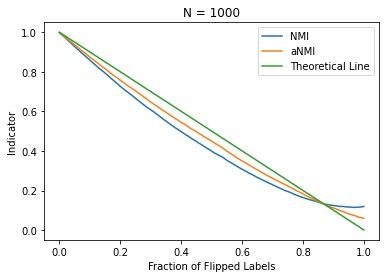

In [73]:
# Create Graph

n = 1000
tau1 = 3
tau2 = 1.5
mu = 0.1
G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=3, min_community=20, seed=10
)
ground_truth = {frozenset(G.nodes[v]["community"]) for v in G}
true_label_list = [0]*len(G)
for index, comm in enumerate(ground_truth):
    for node in comm:
        true_label_list[node] = index
flipped_label_list = true_label_list.copy()
list_nmi_flipped_fraction = []
list_anmi_flipped_fraction = []
list_theoretical = []

print("Calculating Flipping Labels")
for i in range(len(flipped_label_list)):
    
    # flip original label to a different label
    old_label = flipped_label_list[i]
    new_label = random.randint(0, len(ground_truth)-1)
    while new_label == old_label:
            new_label = random.randint(0, len(ground_truth)-1)

    flipped_label_list[i] = new_label
    nmi = nmi_calculator(true_label_list, flipped_label_list)
    anmi = adaptive_nmi(true_label_list, flipped_label_list)
    
    list_nmi_flipped_fraction.append((i/len(flipped_label_list), nmi))
    list_anmi_flipped_fraction.append((i/len(flipped_label_list), anmi))
    list_theoretical.append((i/len(flipped_label_list),1 - i/len(flipped_label_list)))

print("Flipping Labels Complete")
list_nmi_x_axis = [ele[0] for ele in list_nmi_flipped_fraction]
list_nmi_y_axis = [ele[1] for ele in list_nmi_flipped_fraction]

list_anmi_x_axis = [ele[0] for ele in list_anmi_flipped_fraction]
list_anmi_y_axis = [ele[1] for ele in list_anmi_flipped_fraction]

list_theo_x_axis = [ele[0] for ele in list_theoretical]
list_theo_y_axis = [ele[1] for ele in list_theoretical]

print("Plotting")
plt.plot(list_nmi_x_axis, list_nmi_y_axis, label = "NMI")
plt.plot(list_anmi_x_axis, list_anmi_y_axis, label = "aNMI")
plt.plot(list_theo_x_axis, list_theo_y_axis, label = "Theoretical Line")
plt.plot()
plt.legend()

plt.xlabel('Fraction of Flipped Labels')
plt.ylabel('Indicator')
plt.title("N = 1000")

plt.savefig("fig_5_1000.png", format="PNG")


## Figure 7 - Comparison of Evaluation of NMI and Modularity on GN algorithm on Zachary's Karate Graph

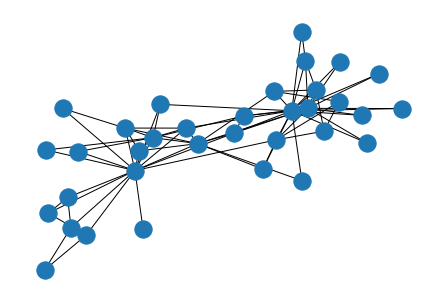

In [74]:
G = nx.karate_club_graph()
my_pos = nx.spring_layout(G, seed = 100)
nx.draw(G, pos=my_pos)

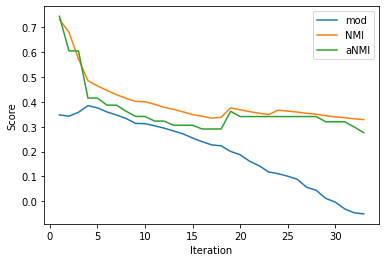

In [75]:
team_1 = {0,1,2,3,4,5,6,7,8,10,11,12,13,16,17,19,21}
team_2 = {i for i in range(0,34)} - team_1
ground_truth = (team_1, team_2)


comp = nx_comm.girvan_newman(G)
# mod_score_list = [nx_comm.modularity(G, next(comp)) for i in range(G.number_of_edges())]
mod_score_list = [nx_comm.modularity(G, next(comp)) for i in range(1, 34)]

# Reset the iterator of GN algorithm
comp = nx_comm.girvan_newman(G)
# print(ground_truth, next(comp))
nmi_score_list = [nmi_calculator(ground_truth, next(comp), G) for i in range(1, 34)]

# Reset the iterator of GN algorithm
comp = nx_comm.girvan_newman(G)
# print(ground_truth, next(comp))
anmi_score_list = [adaptive_nmi(ground_truth, next(comp), G) for i in range(1, 34)]

iteration = [i for i in range(1, 34)]

plt.plot(iteration, mod_score_list, label = "mod")
plt.plot(iteration, nmi_score_list, label = "NMI")
plt.plot(iteration, anmi_score_list, label = "aNMI")

plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Score')
plt.savefig("fig_7.png", format="PNG")


## Karate-NMI

2 0.7446599167174909 1


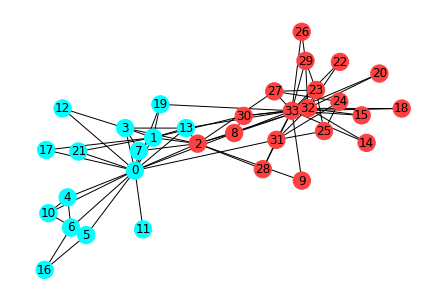

In [76]:
GN_plot_by_eval(G, ground_truth, anmi_score_list)
plt.savefig("fig_7_nmi.png", format="PNG")


2 0.7323776321005694 1


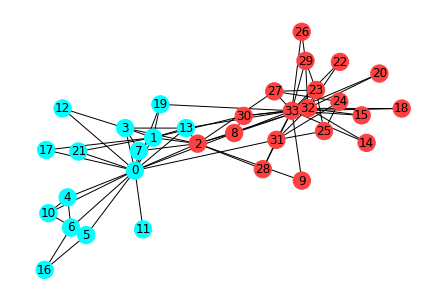

In [185]:
GN_plot_by_eval(G, ground_truth, nmi_score_list)

## Karate-Modularity

7 0.3849721706864564 4


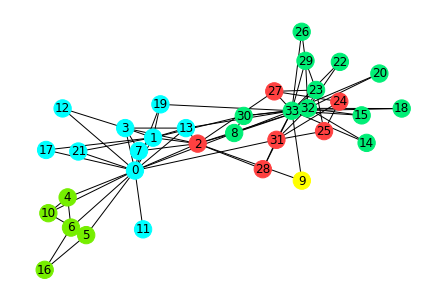

In [79]:
GN_plot_by_eval(G, ground_truth, mod_score_list)
plt.savefig("fig_7_mod.png", format="PNG")

## Karate - Ground Truth

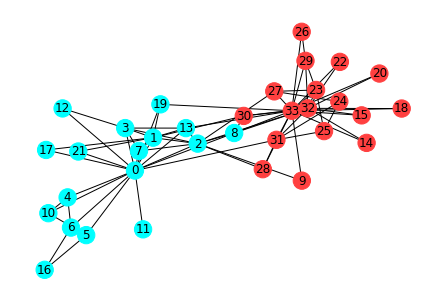

In [80]:
best_partition = (team_1, team_2)
color = ["#00FFFF", "#FF4040", "#76EE00",  "#00EE76", "#FFFF00"]

color_map = []
for node in G:
    for group_index, group in enumerate(best_partition):
        if node in group: color_map.append(color[group_index])

my_pos = nx.spring_layout(G, seed = 100)
nx.draw(G, node_color=color_map, with_labels=True, pos=my_pos)
plt.savefig("fig_7_ground.png", format="PNG")

## Experiment Result - Relabel Mechanics

### Relabel - Default Usage

In [81]:
relabel()

{3: 1, 1: 2, 2: 3}

### Relabel - Network Structure Related

In [82]:
G = nx.karate_club_graph()
computed_partition = ({0, 1, 3, 7, 11, 12, 13, 17, 19, 21},
                      {2, 24, 25, 27, 28, 31},
                      {4, 5, 6, 10, 16},
                      {8, 14, 15, 18, 20, 22, 23, 26, 29, 30, 32, 33},
                      {9})

ground_truth = ({0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 19, 21}, 
                {9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33})
relabel(ground_truth, computed_partition, G)

{0: 0, 3: 1}

### Relabel - Sample

Text(0, 0.5, 'Score')

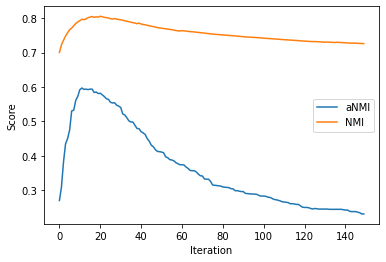

In [83]:
# Construct Sample Network and Ground Truth Partition
n = 1000
tau1 = 3
tau2 = 1.5
mu = 0.1
G = LFR_benchmark_graph(
    n, tau1, tau2, mu, average_degree=2, min_community=20, seed=10
)
ground_truth = tuple({frozenset(G.nodes[v]["community"]) for v in G})

# NMI and aNMI evaluation for each iteration of GN algorthm
max_iter = 150
iteration = [i for i in range(max_iter)]
comp = nx_comm.girvan_newman(G)
anmi_score_list = [adaptive_nmi(ground_truth, next(comp), G) for i in range(max_iter)]

# Reset the iterator of GN algorithm
comp = nx_comm.girvan_newman(G)
nmi_score_list = [nmi_calculator(ground_truth, next(comp), G) for i in range(max_iter)]


plt.plot(iteration, anmi_score_list, label = "aNMI")
plt.plot(iteration, nmi_score_list, label = "NMI")
plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Score')

In [84]:
relabel([2, 2, 2, 2, 3, 3, 3, 1, 1, 4],  [1,1,1,5,5,5,2,3,4])

{1: 2, 5: 3, 2: 4, 3: 1}

## Real-world Data with Communities
Graph is constructed in undirected way due to the author of the algorithm has no intention of adapting to 
directed version, more information in: https://stackoverflow.com/questions/67180053/use-louvain-detection-for-a-direct-graph.

For citing style in Latex, visit: https://snap.stanford.edu/citing.htm

More datasets:
http://dase.ecnu.edu.cn/mgao/links/dataset.html

### Real-world network: email-Eu-core network
https://snap.stanford.edu/data/email-Eu-core.html

In [473]:
g = nx.read_edgelist("network/email-Eu-core.txt",create_using=nx.Graph(), nodetype = int)
node_comms = open("network/email-Eu-core-department-labels.txt").readlines()

# Generate ground-truth label
ground_truth = []
for _ in range(max([int(line.split()[1]) for line in node_comms]) + 1):
    ground_truth.append(set())
for line in node_comms:
    node, comm = (int(ele) for ele in line.split())
    ground_truth[comm].add(node)
    
nx.info(g)

C:\Users\veron\AppData\Local\Temp\ipykernel_19104\4280730405.py:12: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(g)


'Graph with 1005 nodes and 16706 edges'

In [461]:
partition = nx_comm.louvain_communities(g)
df = pd.DataFrame(partition)
df.to_csv('network/email_louvain.csv', index=False)

In [474]:
partition_lv = nx_comm.louvain_communities(g)
anmi_lv = adaptive_nmi(ground_truth, partition_lv, G = g)
nmi_lv = nmi_calculator(ground_truth, partition_lv, G = g)
mod_lv = nx_comm.modularity(g,partition_lv)

In [535]:
mod_lv, nmi_lv, anmi_lv

(0.43056842513944144, 0.5966505291129253, 0.4259800773168888)

In [470]:
print("constructing generator")
generator_gn = nx_comm.girvan_newman(g)
print("constructing partition")
partition_gn = next(generator_gn)
print("Evaluatiing...")
anmi_gn = adaptive_nmi(ground_truth, partition_gn, G = g)
nmi_gn = nmi_calculator(ground_truth, partition_gn, G = g)
mod_gn = nx_comm.modularity(g,partition_gn)

constructing generator
constructing partition
Evaluatiing...


In [536]:
mod_gn, nmi_gn, anmi_gn

(0.0031089277455570302, 0.042166284588186456, 0.052546853133046974)

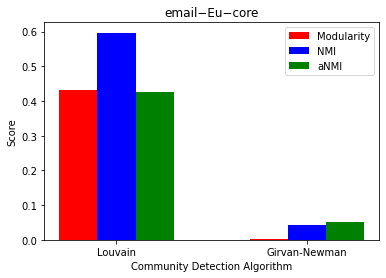

<Figure size 432x288 with 0 Axes>

In [26]:
x = np.arange(2)
mod_list = [0.43056842513944144, 0.0031089277455570302]
nmi_list = [0.5966505291129253,0.042166284588186456]
anmi_list = [0.4259800773168888, 0.052546853133046974]
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, mod_list, width, color='red')
plt.bar(x, nmi_list, width, color='blue')
plt.bar(x+0.2, anmi_list, width, color='green')
plt.xticks(x, ['Louvain', 'Girvan-Newman'])
plt.xlabel("Community Detection Algorithm")
plt.ylabel("Score")
plt.legend(["Modularity", "NMI", "aNMI"])
plt.title("email−Eu−core")
plt.show()
plt.savefig("email−Eu−core.png", format="PNG")

### Real-world network: DBLP collaboration network and ground-truth communities
https://snap.stanford.edu/data/com-DBLP.html

In [521]:
g = nx.read_edgelist("network/com-dblp.ungraph.txt",create_using=nx.Graph(), nodetype = int)
comms_raw = open("network/com-dblp.all.cmty.txt").readlines()

# Generate ground-truth label
ground_truth = dict()
overlap_checker = set()

for index, line in enumerate(comms_raw):
    community = set(int(ele) for ele in line.split()) - overlap_checker
    
    # vertex: community index
    for v in community:
        ground_truth[v] = index
        
    overlap_checker = overlap_checker.union(community)

# Assign vertex with no community label into the last community.
for v in (set(g) - overlap_checker):
    ground_truth[v] = -1

# Generate louvain partition
dblp_partition_lv = nx_comm.louvain_communities(g)

In [532]:
# Convert incontinuous vertex id from dictionary to list

dblp_lv_dict = {}
for index, comm in enumerate(dblp_partition_lv):
    for v in comm:
        dblp_lv_dict[v] = index
         
ground_truth_list = [ground_truth[key] for key in sorted(ground_truth.keys())]
dblp_lv_list = [dblp_lv_dict[key] for key in sorted(dblp_lv_dict.keys())]

(317080, 317080)

### DBLP Louvain

In [533]:
dblp_mod_lv = nx_comm.modularity(g,dblp_partition_lv)
dblp_nmi_lv = nmi_calculator(ground_truth_list, dblp_lv_list)
dblp_anmi_lv = adaptive_nmi(ground_truth_list, dblp_lv_list)

In [534]:
dblp_mod_lv,dblp_nmi_lv,dblp_anmi_lv

(0.8218472333608878, 0.36470040626163397, 0.18464378111246835)

### DBLP GN

In [ ]:
dblp_gn_generator = nx_comm.girvan_newman(g)
dblp_partition_gn = next(dblp_gn_generator)

In [ ]:
dblp_gn_dict = {}
for index, comm in enumerate(dblp_partition_gn):
    for v in comm:
        dblp_gn_dict[v] = index
dblp_gn_list = [dblp_gn_dict[key] for key in sorted(dblp_gn_dict.keys())]        

dblp_mod_gn = nx_comm.modularity(g,dblp_partition_gn)
dblp_nmi_gn = nmi_calculator(ground_truth_list, dblp_gn_list)
dblp_anmi_gn = adaptive_nmi(ground_truth_list, dblp_gn_list)

In [ ]:
dblp_mod_gn, dblp_nmi_gn, dblp_anmi_gn

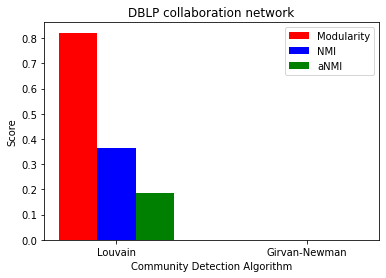

<Figure size 432x288 with 0 Axes>

In [27]:
x = np.arange(2)
mod_list = [0.8218472333608878, 0]
nmi_list = [0.36470040626163397,0]
anmi_list = [0.18464378111246835, 0]
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, mod_list, width, color='red')
plt.bar(x, nmi_list, width, color='blue')
plt.bar(x+0.2, anmi_list, width, color='green')
plt.xticks(x, ['Louvain', 'Girvan-Newman'])
plt.xlabel("Community Detection Algorithm")
plt.ylabel("Score")
plt.legend(["Modularity", "NMI", "aNMI"])
plt.title("DBLP collaboration network")
plt.show()
plt.savefig("DBLP collaboration network.png", format="PNG")

### Code for other evaluations

In [455]:
def lfr_eval_1(metric=nmi_calculator):
    list_louvain = []
    list_gn = []

    for network_size in range(100, 1000, 25):
        tau1 = 2.5
        tau2 = 1.5
        mu = 0.5
        try:
            G = LFR_benchmark_graph(
                network_size, tau1, tau2, mu, average_degree=3, seed=10
            )
            ground_truth = tuple({frozenset(G.nodes[v]["community"]) for v in G})
            partition_lv = nx_comm.louvain_communities(G)
            
            # Take the result of first iteration of gn algorithm as evaluation
            gn_generator = nx_comm.girvan_newman(G)
            partition_gn = next(gn_generator)
        except nx.ExceededMaxIterations:
            continue
        if metric == nmi_calculator:
            list_louvain.append((network_size,metric(ground_truth, partition_lv, G)))
            list_gn.append((network_size,metric(ground_truth, partition_gn, G)))
            y_label = "NMI"
        elif metric == adaptive_nmi:
            list_louvain.append((network_size,metric(ground_truth, partition_lv, G)))
            list_gn.append((network_size,metric(ground_truth, partition_gn, G)))
            y_label = "aNMI"
        else:
            list_louvain.append((network_size,metric(G, partition_lv, )))
            list_gn.append((network_size,metric(G, partition_gn)))
            y_label = "Modularity"
    # Plotting 
    plt.plot([ele[0] for ele in list_louvain], [ele[1] for ele in list_louvain], label = "Louvain")
    plt.plot([ele[0] for ele in list_gn], [ele[1] for ele in list_gn], label = "GN")

    plt.legend()

    plt.xlabel('Size of Network')
    plt.ylabel(y_label)

    plt.savefig(f"fig_alg_{y_label}.png", format="PNG")

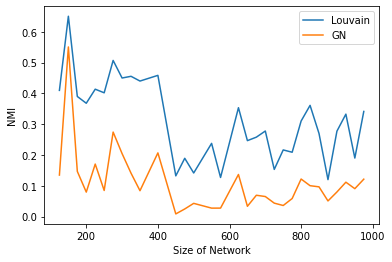

In [451]:
lfr_eval_1()

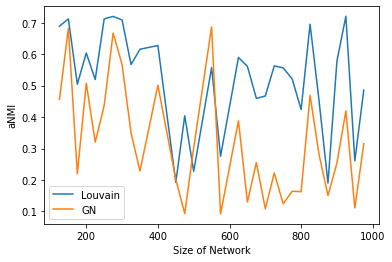

In [457]:
lfr_eval_1(adaptive_nmi)

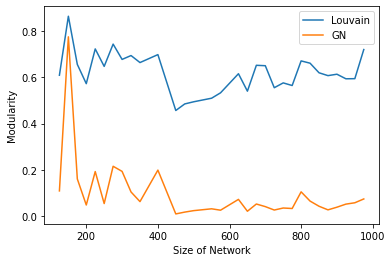

In [454]:
lfr_eval_1(nx_comm.modularity)

In [344]:
def lfr_eval_2(metric = nmi_calculator, eval_name="NMI"):
    list_eval = [[],[],[]]
    list_sizes = [1000,2000,5000]
    for index_size, network_size in enumerate(list_sizes):
        max_comm_size = int(network_size/10)
        step_size = int(max_comm_size/100) if max_comm_size/100 >= 1 else 1
        for comm_size in range(1, max_comm_size, step_size):
            n = network_size
            tau1 = 2.5
            tau2 = 1.5
            mu = 0.5
            try:
                G = LFR_benchmark_graph(
                    n, tau1, tau2, mu, average_degree=2, seed=10, min_community=comm_size
                )
                ground_truth = tuple({frozenset(G.nodes[v]["community"]) for v in G})
                comm_count = len(ground_truth)

                if comm_count > 100:
                    continue
            except nx.ExceededMaxIterations:
                continue

            # True label
            true_label_list = [0]*len(G)
            for index, comm in enumerate(ground_truth):
                for node in comm:
                    true_label_list[node] = index

            # Record the value with the average of 5 trails
            value = 0
            flipped_label_list = true_label_list.copy()
            # create independent parititon from ground truth partition
            for i in range(len(true_label_list)):
                old_label = flipped_label_list[i]
                new_label = random.randint(0, comm_count)
                while new_label == old_label:
                    new_label = random.randint(0, comm_count)

                flipped_label_list[i] = new_label

            # Record the evaluation score
            value += metric(true_label_list, flipped_label_list)

            list_eval[index_size].append((comm_count,value))
        list_eval[index_size] = sorted(list_eval[index_size], key=itemgetter(0))
        
        # Plot the line
        plt.plot([ele[0] for ele in list_eval[index_size]], [ele[1] for ele in list_eval[index_size]], label = "n="+str(network_size))
    
    plt.legend()

    plt.xlabel('Number of Communities')
    plt.ylabel(eval_name)
    
    # Generate image of the experiment
    plt.savefig(f"ind_par_{eval_name}.png", format="PNG")

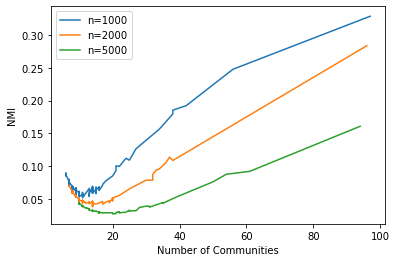

In [345]:
lfr_eval_2()

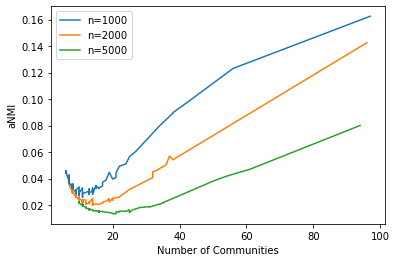

In [346]:
lfr_eval_2(adaptive_nmi,"aNMI")

In [381]:
def lfr_eval_3():
    metric = nmi_calculator
    list_nmi = []
    list_anmi = []

    n = 3000
    tau1 = 2.5
    tau2 = 1.5
    mu = 0.5
    G = LFR_benchmark_graph(
        n, tau1, tau2, mu, average_degree=3, seed=10, min_community=50
    )

    ground_truth = tuple({frozenset(G.nodes[v]["community"]) for v in G})
    comm_count = len(ground_truth)
    print(comm_count)

    true_label_list = [0]*len(G)
    for index, comm in enumerate(ground_truth):
        for node in comm:
            true_label_list[node] = index

    # create independent pari titon from ground truth partition
    for pred_comm_count in range(1, n):
        value = 0
        flipped_label_list = true_label_list.copy()
        for i in range(len(true_label_list)):
            old_label = flipped_label_list[i]
            new_label = random.randint(0, pred_comm_count)
            while new_label == old_label:
                new_label = random.randint(0, pred_comm_count)

            flipped_label_list[i] = new_label

        # Record the evaluation score
        list_nmi.append((pred_comm_count,nmi_calculator(true_label_list, flipped_label_list)))
        list_anmi.append((pred_comm_count,adaptive_nmi(true_label_list, flipped_label_list)))


    plt.plot([ele[0] for ele in list_nmi], [ele[1] for ele in list_nmi], label = "NMI")
    plt.plot([ele[0] for ele in list_anmi], [ele[1] for ele in list_anmi], label = "aNMI")


    plt.legend()

    plt.xlabel('Number of Communities')
    plt.ylabel("Score")

    # Generate image of the experiment
    plt.savefig(f"ind_par_3000.png", format="PNG")

24


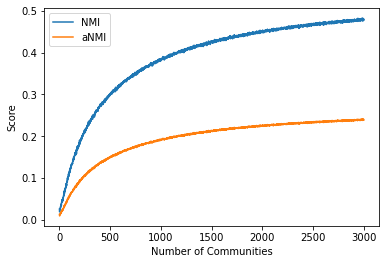

In [382]:
lfr_eval_3()